In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('KO')
    limit 100
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,KO,2005-01-03 06:00:00,20.950
1,KO,2005-01-04 06:00:00,20.770
2,KO,2005-01-05 06:00:00,20.500
3,KO,2005-01-06 06:00:00,20.345
4,KO,2005-01-07 06:00:00,20.535


### Clean data

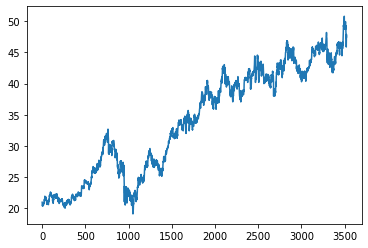

In [3]:
plt.plot(df['open'])
plt.show()

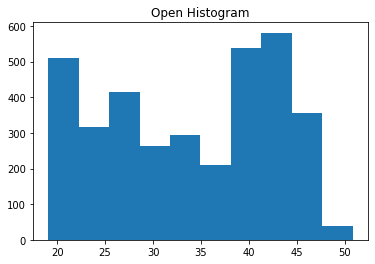

In [4]:
plt.hist(df['open'])
plt.title('Open Histogram')
plt.show()

### Lstm on open data

In [5]:
df['open_min'] = df['open'].rolling(100).min()
df['open_max'] = df['open'].rolling(100).max()

df['target'] = (df['open'] - df['open_min'])/(df['open_max'] - df['open_min'])

df = df[df['target'].notnull()]

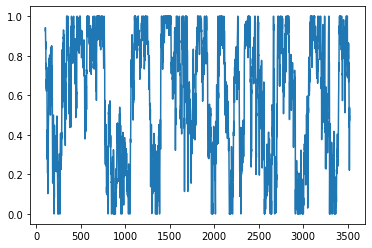

In [6]:
plt.plot(df['target'])
plt.show()

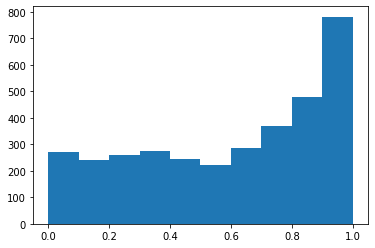

In [7]:
plt.hist(df['target'])
plt.show()

In [8]:
x_temp = df['target'].values

sequence_length = 100

x = []
y = []

for n in range(len(x_temp) - sequence_length - 1):
    x_i = x_temp[n : n + sequence_length]
    y_i = x_temp[n + sequence_length]
    
    x.append(x_i)
    y.append(y_i)

x_arr = np.array(x)
y_arr = np.array(y)

print(len(x_arr))

3324


In [9]:
model = nn_utils.TorchLSTM(train_x=pd.DataFrame(x_arr).head(1000), 
                           train_y=pd.DataFrame(y_arr).head(1000),
                           test_x=pd.DataFrame(x_arr).tail(1000), 
                           test_y=pd.DataFrame(y_arr).tail(1000),
                           n_layers=2,
                           n_epochs=1000,
                           hidden_shape=1000,
                           batch_size=10,
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0')

Epoch  0 Error:  618.93798828125
Epoch  100 Error:  142.7306365966797
Epoch  200 Error:  90.23656463623047
Epoch  300 Error:  71.52095794677734
Epoch  400 Error:  62.51298141479492
Epoch  500 Error:  57.888633728027344
Epoch  600 Error:  55.28907012939453
Epoch  700 Error:  49.73223876953125
Epoch  800 Error:  47.259151458740234
Epoch  900 Error:  45.02407455444336


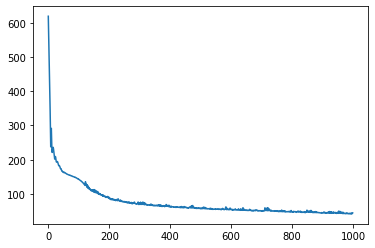

In [10]:
model.execute()

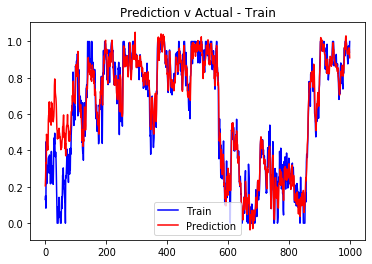

In [11]:
model.plot_prediction_train()

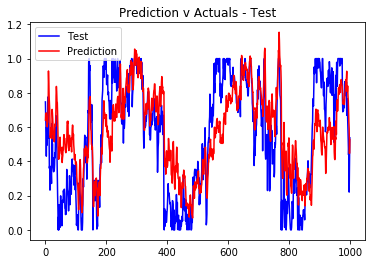

In [12]:
model.plot_prediction_test()

In [13]:
model.reset_network()

In [14]:
test_df = model.test_df
temp = df.tail(1000).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,actuals,prediction,symbol,market_datetime,open,open_min,open_max,target
0,0.611511,0.745803,0.697842,0.731415,0.731415,0.738609,0.760192,0.787440,0.759358,0.781081,...,0.594533,0.681093,0.747153,0.640795,KO,2015-01-12 06:00:00,43.07,40.19,44.58,0.656036
1,0.745803,0.697842,0.731415,0.731415,0.738609,0.760192,0.787440,0.759358,0.781081,0.759459,...,0.681093,0.747153,0.656036,0.679219,KO,2015-01-13 06:00:00,42.83,40.19,44.58,0.601367
2,0.697842,0.731415,0.731415,0.738609,0.760192,0.787440,0.759358,0.781081,0.759459,0.805405,...,0.747153,0.656036,0.601367,0.673687,KO,2015-01-14 06:00:00,42.08,40.19,44.58,0.430524
3,0.731415,0.731415,0.738609,0.760192,0.787440,0.759358,0.781081,0.759459,0.805405,0.835135,...,0.656036,0.601367,0.430524,0.682995,KO,2015-01-15 06:00:00,42.83,40.19,44.58,0.601367
4,0.731415,0.738609,0.760192,0.787440,0.759358,0.781081,0.759459,0.805405,0.835135,0.832317,...,0.601367,0.430524,0.601367,0.634703,KO,2015-01-16 06:00:00,42.36,40.19,44.58,0.494305


In [15]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']

In [16]:
test_df[['open', 'prediction_mapped']].head()

,open,prediction_mapped
0,43.07,43.003088
1,42.83,43.171771
2,42.08,43.147486
3,42.83,43.188350
4,42.36,42.976345


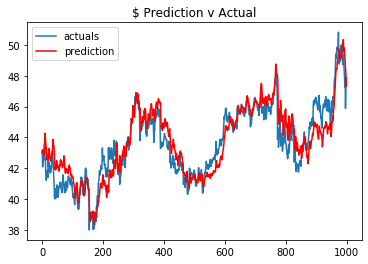

In [17]:
plt.title('$ Prediction v Actual')
plt.plot(test_df['open'], label='actuals')
plt.plot(test_df['prediction_mapped'], color='r', label='prediction')
plt.legend()
plt.show()

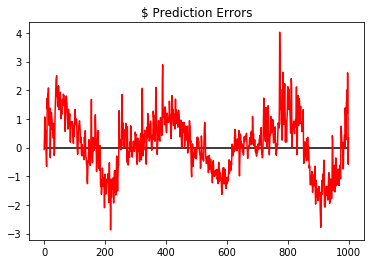

In [18]:
plt.title('$ Prediction Errors')
plt.plot(test_df['prediction_mapped']-test_df['open'], color='r')
plt.hlines(0, xmin=test_df.index.min(), xmax=test_df.index.max())
plt.show()

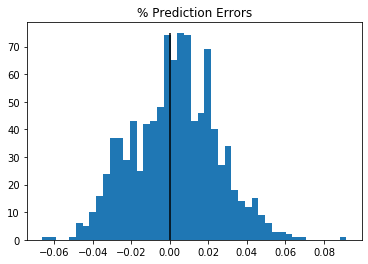

In [19]:
plt.title('% Prediction Errors')
plot = plt.hist((test_df['prediction_mapped']-test_df['open'])/test_df['open'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()

In [20]:
test_df['transaction'] = 'nothing'
test_df['predicted_change'] = test_df['prediction_mapped'].shift(-1) - test_df['open']
test_df.loc[test_df['predicted_change'] > 0, 'transaction'] = 'buy'
test_df.loc[test_df['predicted_change'] < 0, 'transaction'] = 'sell'

test_df[['open', 'prediction_mapped', 'transaction']].tail(20)

,open,prediction_mapped,transaction
980,49.00,49.176065,buy
981,49.87,49.124549,sell
982,49.97,49.296694,sell
983,49.51,49.531484,buy
984,49.57,49.647126,buy
985,49.45,49.767874,buy
986,49.59,50.038214,buy
987,49.95,49.958378,buy
988,48.72,50.104702,buy
989,49.23,50.351685,buy


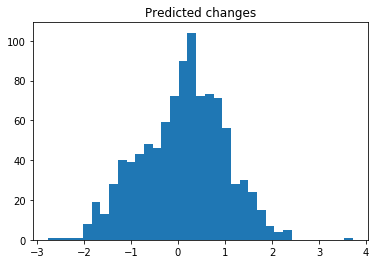

In [21]:
plt.title('Predicted changes')
plt.hist(test_df.loc[test_df['predicted_change'].notnull(), 'predicted_change'], bins=35)
plt.show()

### Long short with kelly criterion

Annualized P/L 0.00316


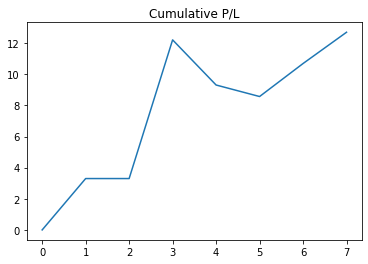

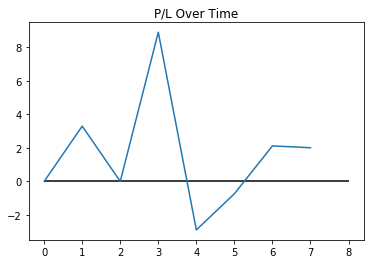

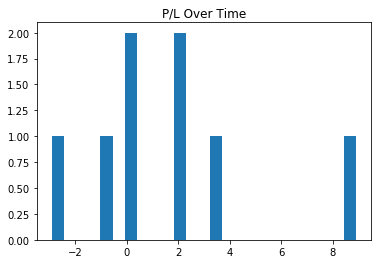

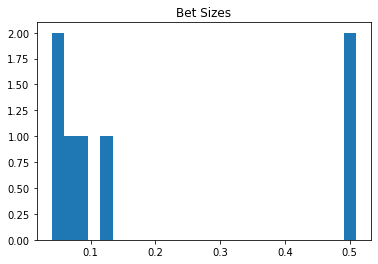

In [22]:
long = False
short = False
profit_loss = [0]
bet_sizes = []
portfolio_size = 1000

for idx, row in test_df.iterrows():
    if row['transaction'] == 'buy' and short:
        n_shares = int((bet_size * portfolio_size)/price)
        profit_loss.append(n_shares * (price - row['open']))
        short = False
    elif row['transaction'] == 'sell' and long:
        n_shares = int((bet_size * portfolio_size)/price)
        profit_loss.append(n_shares * (row['open'] - price))
        long = False
    if not long and not short:
        bet_size = financial_utils.kelly_criterion(abs(row['predicted_change']), 
                                                   np.median(np.abs(profit_loss)), 
                                                   .51, .49)
        if bet_size > 0:
            price = row['open']
            bet_sizes.append(bet_size)
            if row['transaction'] == 'buy':
                long = True
            elif row['transaction'] == 'sell':
                short = True

annualized_return = (1+sum(profit_loss)/portfolio_size)**(1/(len(test_df)/250))-1
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.title('Cumulative P/L')
plt.plot(np.cumsum(profit_loss))
plt.show()

plt.title('P/L Over Time')
plt.plot(profit_loss)
plt.hlines(0, xmin=0, xmax=len(profit_loss))
plt.show()

plt.title('P/L Over Time')
plt.hist(profit_loss, bins=25)
plt.show()

plt.title('Bet Sizes')
plt.hist(bet_sizes, bins=25)
plt.show()

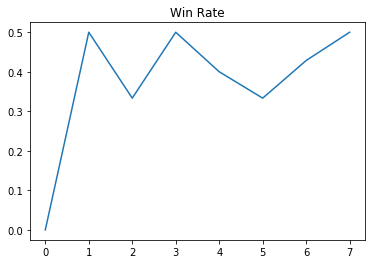

,profits,bet_size,win,loss,cumulative_wins,cumulative_losses,win_rate
0,0.00,0.510000,0,1,0,1,0.000000
1,3.30,0.039894,1,0,1,1,0.500000
2,0.00,0.510000,0,1,1,2,0.333333
3,8.91,0.088806,1,0,2,2,0.500000
4,-2.90,0.127443,0,1,2,3,0.400000
5,-0.74,0.047625,0,1,2,4,0.333333
6,2.12,0.065622,1,0,3,4,0.428571
7,2.01,NaN,1,0,4,4,0.500000


In [23]:
pl = pd.DataFrame(profit_loss, columns=['profits']).join(pd.DataFrame(bet_sizes, columns=['bet_size']))

pl['win'] = 0
pl['loss'] = 0
pl.loc[pl['profits'] > 0, 'win'] = 1
pl.loc[pl['profits'] <= 0, 'loss'] = 1

pl['cumulative_wins'] = pl['win'].cumsum()
pl['cumulative_losses'] = pl['loss'].cumsum()

pl['win_rate'] = pl['cumulative_wins']/(pl['cumulative_wins'] + pl['cumulative_losses'])

plt.title('Win Rate')
plt.plot(pl['win_rate'])
plt.show()

pl.head(20)

In [24]:
model.forward().shape

torch.Size([100, 10, 1])